# SSY340 Project - Trajectory Estimation LSTM

### Fill in group number and member names:

In [1]:
NAME1 = "Bingcheng Chen" 
NAME2 = "Arvin Rokni"
GROUP = "Project groups 64"

## 1. Loading the data

In [2]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import os
import dataloader
import model_LSTM_attention
import utils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## 2. Pre-processing

In [3]:
# defining model save location
save_location = "./LSTM_Attention_models"
# defining dataset locations
dataset_folder = "./datasets"
dataset_name = "raw"
# setting validation size. if val_size = 0, split percentage is 80-20
val_size = 0
# length of sequence given to encoder
gt = 8
# length of sequence given to decoder
horizon = 12


train_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size,
                                             gt, horizon, delim="\t", train=True)
val_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size,
                                           gt, horizon, delim="\t", train=False)
# test_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
#     gt, horizon, delim="\t", train=False, eval=True)

In [4]:
val_dataset[10]

{'src': tensor([[ 4.9693e+00,  8.3395e+00,  0.0000e+00,  0.0000e+00],
         [ 5.1330e+00,  8.3350e+00,  1.6374e-01, -4.5338e-03],
         [ 5.2968e+00,  8.3307e+00,  1.6374e-01, -4.2963e-03],
         [ 5.3915e+00,  8.3490e+00,  9.4709e-02,  1.8377e-02],
         [ 5.4565e+00,  8.3774e+00,  6.5034e-02,  2.8400e-02],
         [ 5.5218e+00,  8.4058e+00,  6.5244e-02,  2.8400e-02],
         [ 5.5868e+00,  8.4342e+00,  6.5033e-02,  2.8400e-02],
         [ 5.5988e+00,  8.4497e+00,  1.1997e-02,  1.5512e-02]]),
 'trg': tensor([[ 5.5575e+00,  8.4521e+00, -4.1251e-02,  2.3870e-03],
         [ 5.5163e+00,  8.4548e+00, -4.1251e-02,  2.6255e-03],
         [ 5.4750e+00,  8.4571e+00, -4.1251e-02,  2.3861e-03],
         [ 5.4340e+00,  8.4595e+00, -4.1041e-02,  2.3870e-03],
         [ 5.3927e+00,  8.4622e+00, -4.1251e-02,  2.6245e-03],
         [ 5.3515e+00,  8.4645e+00, -4.1251e-02,  2.3870e-03],
         [ 5.3102e+00,  8.4669e+00, -4.1251e-02,  2.3861e-03],
         [ 5.2690e+00,  8.4696e+00, -4.

In [5]:
val_dataset[10]['src'].shape

torch.Size([8, 4])

## 3. Data loaders

In [6]:
# defining batch size
batch_size = 64

# creating torch dataloaders
train_loader = DataLoader(train_dataset, batch_size,
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=0)

## 4. Training

#### 4.1 create a model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LSTM_attn_model = model_LSTM_attention.LSTM_Dual_Attention(
        input_size = 2, input_seq_len = 8, hidden_size = 128, num_layers = 2, output_size = 2, output_seq_len = 12, embedding_size = 8, num_heads = 2).to(device)

In [8]:
LSTM_attn_model

LSTM_Dual_Attention(
  (encoder): Encoder(
    (encoder_embedding): Embeddings(
      (linear_embd): Linear(in_features=2, out_features=8, bias=True)
    )
    (norm_input): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (encoder_attn): MultiHeadAttention(
      (W_q): Linear(in_features=8, out_features=8, bias=True)
      (W_k): Linear(in_features=8, out_features=8, bias=True)
      (W_v): Linear(in_features=8, out_features=8, bias=True)
      (W_o): Linear(in_features=8, out_features=8, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder_lstm): LSTM(
      (LSTM_first_layer): ModuleList(
        (0): LSTMCell(
          (W_hh): Linear(in_features=128, out_features=512, bias=True)
          (W_xh): Linear(in_features=8, out_features=512, bias=True)
        )
        (1): LSTMCell(
          (W_hh): Linear(in_features=128, out_features=512, bias=True)
          (W_xh): Linear(in_features=128, out_features=512, bias=True)
        )
      )
      (LSTM_w

#### 4.2 The training loop

In [9]:
# number of epochs
epochs = 100

# metric variables
training_loss = []
validation_loss = []
val_mad = []
val_fad = []

# Define the MSE loss function
criterion = nn.MSELoss()

learning_rate = 0.001
# optimizer = torch.optim.SGD(LSTM_attn_model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(LSTM_attn_model.parameters(), lr=learning_rate)
# optimizer = torch.optim.AdamW(LSTM_attn_model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

for epoch in tqdm(range(epochs)):
    # TRAINING MODE
    LSTM_attn_model.train()

    # training batch variables
    train_batch_loss = 0

    for idx, data in enumerate(train_loader):
        # getting encoder input data
        X = data['src'][:, :, 0:2].to(device)
        target = data['trg'][:, :, 0:2].to(device)

        # forward pass
        optimizer.zero_grad()
        # predictions = tf_model.forward(enc_input, dec_input, dec_source_mask, dec_target_mask)
        predictions = LSTM_attn_model.forward(X)

        loss = criterion(predictions.view(X.size(0), -1),
                         target.contiguous().view(X.size(0), -1))
        train_batch_loss += loss.item()

        # updating weights
        loss.backward()
        optimizer.step()

    training_loss.append(train_batch_loss/len(train_loader))
    print("Epoch {}/{}....Training loss = {:.4f}".format(epoch +
                                                         1, epochs, training_loss[-1]))

    # validation loop
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            # EVALUATION MODE
            LSTM_attn_model.eval()

            # validation variables
            batch_val_loss = 0
            gt = []
            pr = []

            for id_b, data in enumerate(val_loader):
                # storing groung truth
                truth = data['trg'][:, :, 0:2].to(device)
                gt.append(data['trg'][:, :, 0:2])
                # input to encoder input
                val_input = data['src'][:, :, 0:2].to(device)
                # prediction till horizon lenght
                model_output = LSTM_attn_model.forward(val_input)
                pr.append(model_output.view(val_input.size(0), 12, -1).cpu())

                # calculating loss using pairwise distance of all predictions
                val_loss = criterion(model_output.view(val_input.size(
                    0), -1), truth.contiguous().view(val_input.size(0), -1))
                batch_val_loss += val_loss.item()

            validation_loss.append(batch_val_loss/len(val_loader))

            # calculating mad and fad evaluation metrics
            gt = np.concatenate(gt, 0)
            pr = np.concatenate(pr, 0)
            mad, fad, _ = dataloader.distance_metrics(gt, pr)
            val_mad.append(mad)
            val_fad.append(fad)

            print("Epoch {}/{}....Validation mad = {:.4f}, Validation fad = {:.4f}".format(
                epoch+1, epochs, mad, fad))

    if (epoch+1)%10 == 0:
        # Saving model, loss and error log files
        torch.save({
            'model_state_dict': LSTM_attn_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training_loss': training_loss,
            'validation_loss': validation_loss,
            'val_mad': val_mad,
            'val_fad': val_fad,
            'learning_rate': learning_rate
        }, os.path.join(save_location, 'LSTM_Attn_epoch{}.pth'.format(epoch+1)))


  1%|██                                                                                                                                                                                                          | 1/100 [00:19<32:05, 19.45s/it]

Epoch 1/100....Training loss = 10.5705


  2%|████                                                                                                                                                                                                        | 2/100 [00:38<30:54, 18.93s/it]

Epoch 2/100....Training loss = 6.8624


  3%|██████                                                                                                                                                                                                      | 3/100 [00:56<30:23, 18.80s/it]

Epoch 3/100....Training loss = 6.6677


  4%|████████▏                                                                                                                                                                                                   | 4/100 [01:15<29:59, 18.75s/it]

Epoch 4/100....Training loss = 6.2594
Epoch 5/100....Training loss = 3.9406


  5%|██████████▏                                                                                                                                                                                                 | 5/100 [01:35<30:41, 19.39s/it]

Epoch 5/100....Validation mad = 2.1871, Validation fad = 3.2502


  6%|████████████▏                                                                                                                                                                                               | 6/100 [01:54<30:03, 19.19s/it]

Epoch 6/100....Training loss = 3.4477


  7%|██████████████▎                                                                                                                                                                                             | 7/100 [02:13<29:31, 19.05s/it]

Epoch 7/100....Training loss = 3.2292


  8%|████████████████▎                                                                                                                                                                                           | 8/100 [02:32<29:06, 18.98s/it]

Epoch 8/100....Training loss = 2.9469


  9%|██████████████████▎                                                                                                                                                                                         | 9/100 [02:51<28:41, 18.92s/it]

Epoch 9/100....Training loss = 2.3635
Epoch 10/100....Training loss = 2.1415


 10%|████████████████████▎                                                                                                                                                                                      | 10/100 [03:11<29:07, 19.42s/it]

Epoch 10/100....Validation mad = 1.6469, Validation fad = 2.5219


 11%|██████████████████████▎                                                                                                                                                                                    | 11/100 [03:30<28:34, 19.26s/it]

Epoch 11/100....Training loss = 1.8918


 12%|████████████████████████▎                                                                                                                                                                                  | 12/100 [03:49<27:59, 19.09s/it]

Epoch 12/100....Training loss = 1.6393


 13%|██████████████████████████▍                                                                                                                                                                                | 13/100 [04:07<27:26, 18.93s/it]

Epoch 13/100....Training loss = 1.5031


 14%|████████████████████████████▍                                                                                                                                                                              | 14/100 [04:26<27:04, 18.89s/it]

Epoch 14/100....Training loss = 1.4003
Epoch 15/100....Training loss = 1.3313


 15%|██████████████████████████████▍                                                                                                                                                                            | 15/100 [04:46<27:17, 19.26s/it]

Epoch 15/100....Validation mad = 1.2582, Validation fad = 1.9880


 16%|████████████████████████████████▍                                                                                                                                                                          | 16/100 [05:05<26:44, 19.10s/it]

Epoch 16/100....Training loss = 1.2641


 17%|██████████████████████████████████▌                                                                                                                                                                        | 17/100 [05:23<26:13, 18.96s/it]

Epoch 17/100....Training loss = 1.2128


 18%|████████████████████████████████████▌                                                                                                                                                                      | 18/100 [05:42<25:47, 18.87s/it]

Epoch 18/100....Training loss = 1.1707


 19%|██████████████████████████████████████▌                                                                                                                                                                    | 19/100 [06:01<25:21, 18.79s/it]

Epoch 19/100....Training loss = 1.1631
Epoch 20/100....Training loss = 1.1281


 20%|████████████████████████████████████████▌                                                                                                                                                                  | 20/100 [06:21<25:33, 19.17s/it]

Epoch 20/100....Validation mad = 1.0637, Validation fad = 1.7582


 21%|██████████████████████████████████████████▋                                                                                                                                                                | 21/100 [06:39<24:52, 18.90s/it]

Epoch 21/100....Training loss = 1.0992


 22%|████████████████████████████████████████████▋                                                                                                                                                              | 22/100 [06:57<24:20, 18.72s/it]

Epoch 22/100....Training loss = 1.0792


 23%|██████████████████████████████████████████████▋                                                                                                                                                            | 23/100 [07:16<23:52, 18.60s/it]

Epoch 23/100....Training loss = 1.0711


 24%|████████████████████████████████████████████████▋                                                                                                                                                          | 24/100 [07:34<23:26, 18.51s/it]

Epoch 24/100....Training loss = 1.0121
Epoch 25/100....Training loss = 0.9706


 25%|██████████████████████████████████████████████████▊                                                                                                                                                        | 25/100 [07:54<23:39, 18.93s/it]

Epoch 25/100....Validation mad = 1.1313, Validation fad = 1.8330


 26%|████████████████████████████████████████████████████▊                                                                                                                                                      | 26/100 [08:12<23:09, 18.77s/it]

Epoch 26/100....Training loss = 0.9494


 27%|██████████████████████████████████████████████████████▊                                                                                                                                                    | 27/100 [08:31<22:47, 18.73s/it]

Epoch 27/100....Training loss = 0.9041


 28%|████████████████████████████████████████████████████████▊                                                                                                                                                  | 28/100 [08:49<22:18, 18.59s/it]

Epoch 28/100....Training loss = 0.8860


 29%|██████████████████████████████████████████████████████████▊                                                                                                                                                | 29/100 [09:07<21:52, 18.48s/it]

Epoch 29/100....Training loss = 0.8466
Epoch 30/100....Training loss = 0.8337


 30%|████████████████████████████████████████████████████████████▉                                                                                                                                              | 30/100 [09:27<22:05, 18.93s/it]

Epoch 30/100....Validation mad = 1.0533, Validation fad = 1.8205


 31%|██████████████████████████████████████████████████████████████▉                                                                                                                                            | 31/100 [09:46<21:31, 18.72s/it]

Epoch 31/100....Training loss = 0.8112


 32%|████████████████████████████████████████████████████████████████▉                                                                                                                                          | 32/100 [10:04<21:02, 18.56s/it]

Epoch 32/100....Training loss = 0.7822


 33%|██████████████████████████████████████████████████████████████████▉                                                                                                                                        | 33/100 [10:22<20:40, 18.52s/it]

Epoch 33/100....Training loss = 0.7728


 34%|█████████████████████████████████████████████████████████████████████                                                                                                                                      | 34/100 [10:40<20:13, 18.38s/it]

Epoch 34/100....Training loss = 0.8258
Epoch 35/100....Training loss = 0.7621


 35%|███████████████████████████████████████████████████████████████████████                                                                                                                                    | 35/100 [11:00<20:22, 18.80s/it]

Epoch 35/100....Validation mad = 0.9449, Validation fad = 1.6042


 36%|█████████████████████████████████████████████████████████████████████████                                                                                                                                  | 36/100 [11:19<19:55, 18.68s/it]

Epoch 36/100....Training loss = 0.7318


 37%|███████████████████████████████████████████████████████████████████████████                                                                                                                                | 37/100 [11:37<19:26, 18.52s/it]

Epoch 37/100....Training loss = 0.7148


 38%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 38/100 [11:55<19:01, 18.40s/it]

Epoch 38/100....Training loss = 0.6977


 39%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 39/100 [12:13<18:36, 18.30s/it]

Epoch 39/100....Training loss = 0.6789
Epoch 40/100....Training loss = 0.6530


 40%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 40/100 [12:33<18:44, 18.74s/it]

Epoch 40/100....Validation mad = 0.8732, Validation fad = 1.4572


 41%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 41/100 [12:51<18:13, 18.54s/it]

Epoch 41/100....Training loss = 0.6536


 42%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 42/100 [13:09<17:43, 18.34s/it]

Epoch 42/100....Training loss = 0.6538


 43%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 43/100 [13:27<17:24, 18.33s/it]

Epoch 43/100....Training loss = 0.6337


 44%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 44/100 [13:45<17:06, 18.33s/it]

Epoch 44/100....Training loss = 0.6560
Epoch 45/100....Training loss = 0.6176


 45%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 45/100 [14:05<17:11, 18.75s/it]

Epoch 45/100....Validation mad = 0.8189, Validation fad = 1.4220


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 46/100 [14:23<16:46, 18.63s/it]

Epoch 46/100....Training loss = 0.6045


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 47/100 [14:41<16:19, 18.47s/it]

Epoch 47/100....Training loss = 0.5819


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 48/100 [15:00<15:57, 18.42s/it]

Epoch 48/100....Training loss = 0.5951


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 49/100 [15:18<15:35, 18.35s/it]

Epoch 49/100....Training loss = 0.5450
Epoch 50/100....Training loss = 0.6314


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 50/100 [15:37<15:36, 18.74s/it]

Epoch 50/100....Validation mad = 0.8779, Validation fad = 1.4885


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 51/100 [15:56<15:11, 18.61s/it]

Epoch 51/100....Training loss = 0.5644


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 52/100 [16:14<14:46, 18.47s/it]

Epoch 52/100....Training loss = 0.5573


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 53/100 [16:32<14:29, 18.49s/it]

Epoch 53/100....Training loss = 0.5429


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 54/100 [16:51<14:06, 18.39s/it]

Epoch 54/100....Training loss = 0.5544
Epoch 55/100....Training loss = 0.5378


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 55/100 [17:10<14:02, 18.73s/it]

Epoch 55/100....Validation mad = 0.7511, Validation fad = 1.2921


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 56/100 [17:28<13:38, 18.60s/it]

Epoch 56/100....Training loss = 0.5370


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 57/100 [17:47<13:13, 18.46s/it]

Epoch 57/100....Training loss = 0.5143


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 58/100 [18:05<12:52, 18.39s/it]

Epoch 58/100....Training loss = 0.5250


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 59/100 [18:23<12:34, 18.40s/it]

Epoch 59/100....Training loss = 0.5695
Epoch 60/100....Training loss = 0.5630


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 60/100 [18:43<12:30, 18.77s/it]

Epoch 60/100....Validation mad = 0.7258, Validation fad = 1.2844


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 61/100 [19:01<12:03, 18.55s/it]

Epoch 61/100....Training loss = 0.5361


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 62/100 [19:19<11:39, 18.40s/it]

Epoch 62/100....Training loss = 0.5145


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 63/100 [19:37<11:16, 18.28s/it]

Epoch 63/100....Training loss = 0.5501


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 64/100 [19:55<10:55, 18.21s/it]

Epoch 64/100....Training loss = 0.5427
Epoch 65/100....Training loss = 0.4999


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 65/100 [20:15<10:52, 18.63s/it]

Epoch 65/100....Validation mad = 0.7604, Validation fad = 1.2904


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 66/100 [20:33<10:30, 18.54s/it]

Epoch 66/100....Training loss = 0.5062


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 67/100 [20:51<10:08, 18.45s/it]

Epoch 67/100....Training loss = 0.5382


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 68/100 [21:09<09:46, 18.34s/it]

Epoch 68/100....Training loss = 0.5290


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 69/100 [21:27<09:26, 18.26s/it]

Epoch 69/100....Training loss = 0.5374
Epoch 70/100....Training loss = 0.4957


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 70/100 [21:47<09:20, 18.67s/it]

Epoch 70/100....Validation mad = 0.7096, Validation fad = 1.2481


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 71/100 [22:05<08:57, 18.53s/it]

Epoch 71/100....Training loss = 0.5148


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 72/100 [22:23<08:34, 18.38s/it]

Epoch 72/100....Training loss = 0.5362


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 73/100 [22:41<08:11, 18.19s/it]

Epoch 73/100....Training loss = 0.4901


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 74/100 [22:59<07:48, 18.03s/it]

Epoch 74/100....Training loss = 0.5637
Epoch 75/100....Training loss = 0.5109


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 75/100 [23:18<07:40, 18.42s/it]

Epoch 75/100....Validation mad = 0.8158, Validation fad = 1.3240


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 76/100 [23:36<07:17, 18.24s/it]

Epoch 76/100....Training loss = 0.4681


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 77/100 [23:54<06:57, 18.14s/it]

Epoch 77/100....Training loss = 0.4913


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 78/100 [24:11<06:36, 18.03s/it]

Epoch 78/100....Training loss = 0.4769


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 79/100 [24:29<06:18, 18.02s/it]

Epoch 79/100....Training loss = 0.4674
Epoch 80/100....Training loss = 0.4988


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 80/100 [24:49<06:07, 18.39s/it]

Epoch 80/100....Validation mad = 0.7399, Validation fad = 1.2726


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 81/100 [25:06<05:45, 18.18s/it]

Epoch 81/100....Training loss = 0.4948


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 82/100 [25:24<05:25, 18.07s/it]

Epoch 82/100....Training loss = 0.4998


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 83/100 [25:42<05:05, 17.95s/it]

Epoch 83/100....Training loss = 0.5394


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 84/100 [26:00<04:46, 17.92s/it]

Epoch 84/100....Training loss = 0.4799
Epoch 85/100....Training loss = 0.4911


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 85/100 [26:19<04:35, 18.34s/it]

Epoch 85/100....Validation mad = 0.8044, Validation fad = 1.3347


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 86/100 [26:37<04:14, 18.15s/it]

Epoch 86/100....Training loss = 0.4960


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 87/100 [26:54<03:54, 18.01s/it]

Epoch 87/100....Training loss = 0.5171


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 88/100 [27:12<03:35, 17.94s/it]

Epoch 88/100....Training loss = 0.4951


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 89/100 [27:30<03:17, 17.94s/it]

Epoch 89/100....Training loss = 0.4806
Epoch 90/100....Training loss = 0.5010


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 90/100 [27:49<03:02, 18.28s/it]

Epoch 90/100....Validation mad = 0.7594, Validation fad = 1.3146


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 91/100 [28:07<02:42, 18.08s/it]

Epoch 91/100....Training loss = 0.5515


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 92/100 [28:25<02:23, 18.00s/it]

Epoch 92/100....Training loss = 0.5122


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 93/100 [28:42<02:05, 17.91s/it]

Epoch 93/100....Training loss = 0.5559


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 94/100 [29:00<01:47, 17.88s/it]

Epoch 94/100....Training loss = 0.5866
Epoch 95/100....Training loss = 0.5336


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 95/100 [29:19<01:31, 18.25s/it]

Epoch 95/100....Validation mad = 0.7588, Validation fad = 1.3348


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 96/100 [29:37<01:12, 18.07s/it]

Epoch 96/100....Training loss = 0.5128


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 97/100 [29:54<00:53, 17.91s/it]

Epoch 97/100....Training loss = 0.5173


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 98/100 [30:12<00:35, 17.83s/it]

Epoch 98/100....Training loss = 0.5348


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 99/100 [30:30<00:17, 17.72s/it]

Epoch 99/100....Training loss = 0.5763
Epoch 100/100....Training loss = 0.5020


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [30:49<00:00, 18.49s/it]

Epoch 100/100....Validation mad = 0.7131, Validation fad = 1.2360


## 5. Visualisation

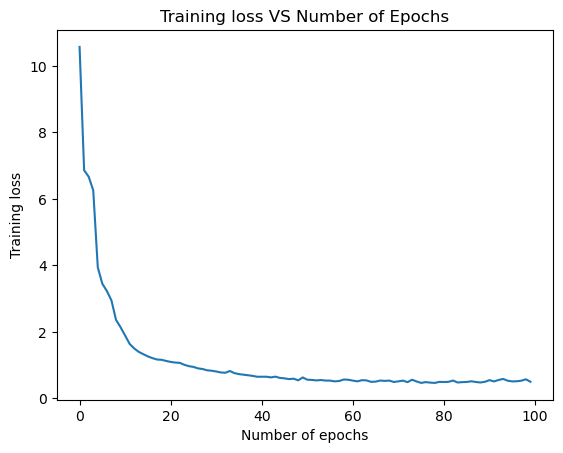

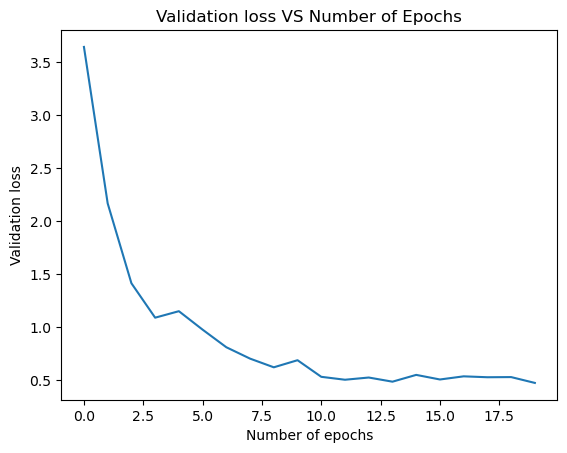

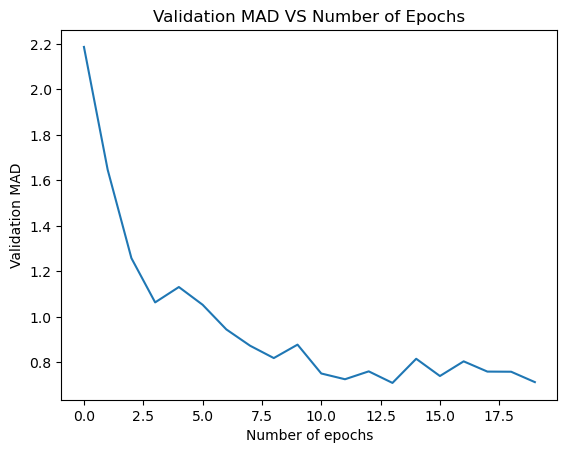

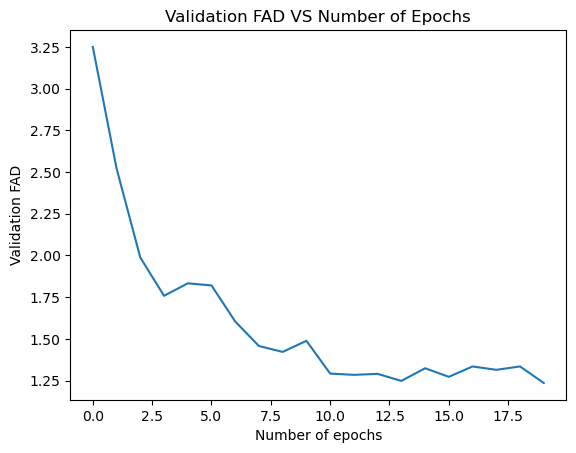

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_file = torch.load(os.path.join(
    save_location, 'LSTM_Attn_epoch100.pth'), map_location=torch.device(device))

# creating model and loading weights
# encoder_ip_size = 2
# decoder_ip_size = 3
# model_op_size = 3
# emb_size = 512
# num_heads = 8
# ff_hidden_size = 2048
# n = 6
# dropout = 0.1

# model_loaded = model.TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size,
#                              num_heads, ff_hidden_size, n, dropout=0.1)

model_loaded = model_LSTM_attention.LSTM_Dual_Attention(
        input_size = 2, input_seq_len = 8, hidden_size = 128, num_layers = 2, output_size = 2, output_seq_len = 12, embedding_size = 8, num_heads = 2).to(device)


model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(loaded_file['model_state_dict'])

# loading training metric variables
training_loss = loaded_file['training_loss']
validation_loss = loaded_file['validation_loss']
val_mad = loaded_file['val_mad']
val_fad = loaded_file['val_fad']
learning_rate = loaded_file['learning_rate']

# plotting training loss
plt.figure()
plt.plot(training_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.title("Training loss VS Number of Epochs")

# plotting validation loss
plt.figure()
plt.plot(validation_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Validation loss")
plt.title("Validation loss VS Number of Epochs")

# plotting learning rate for model
# plt.figure()
# plt.plot(learning_rate)
# plt.xlabel("Number of epochs")
# plt.ylabel("learning_rate")
# plt.title("Learning_rate VS Number of Epochs")

# plotting MAD
plt.figure()
plt.plot(val_mad)
plt.xlabel("Number of epochs")
plt.ylabel("Validation MAD")
plt.title("Validation MAD VS Number of Epochs")

# plotting FAD
plt.figure()
plt.plot(val_fad)
plt.xlabel("Number of epochs")
plt.ylabel("Validation FAD")
plt.title("Validation FAD VS Number of Epochs")

plt.show()

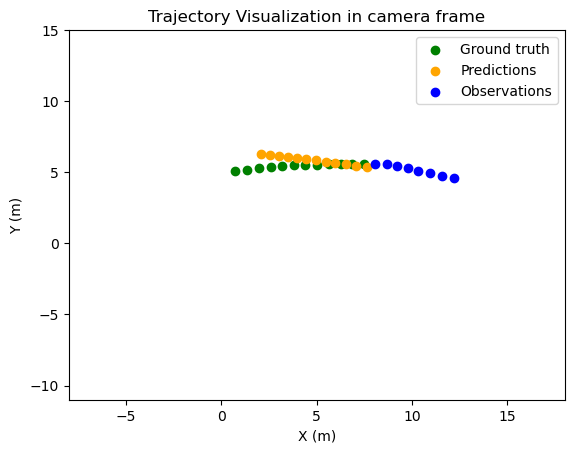

In [11]:
# Running the validation loop to generate prediction trajectories on validation data
validation_loss = []
val_mad = []
val_fad = []

with torch.no_grad():
    # EVALUATION MODE
    model_loaded.eval()

    # validation variables
    batch_val_loss = 0
    gt = []
    pr = []
    obs = []

    for id_b, data in enumerate(val_loader):
        # storing groung truth
        truth = data['trg'][:, :, 0:2].to(device)
        gt.append(data['trg'][:, :, 0:2])
        obs.append(data['src'][:, :, 0:2])
        # input to encoder input
        val_input = data['src'][:, :, 0:2].to(device)

        # prediction till horizon lenght
        model_output = model_loaded.forward(val_input)
        pr.append(model_output.view(val_input.size(0), 12, -1).cpu())

        # calculating loss using pairwise distance of all predictions
        val_loss = criterion(model_output.view(val_input.size(0), -1), truth.contiguous().view(val_input.size(0), -1))
        batch_val_loss += val_loss.item()

        validation_loss.append(batch_val_loss/len(val_loader))

    # calculating mad and fad evaluation metrics
    gt = np.concatenate(gt, 0)
    pr = np.concatenate(pr, 0)
    obs = np.concatenate(obs, 0)
    mad, fad, _ = dataloader.distance_metrics(gt, pr)
    val_mad.append(mad)
    val_fad.append(fad)

# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.savefig("traj_{}".format(idx))

plt.show()

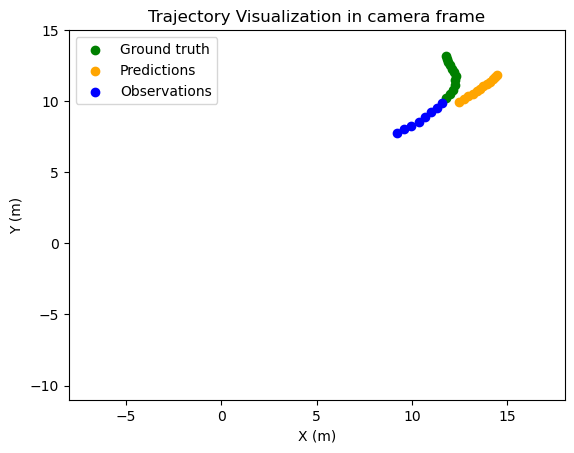

In [14]:
# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
# plt.savefig("traj_{}".format(idx))

plt.show()

## 6. Evaluation on test set